**Mount to google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

# Define the zip file and extraction path
zip_file_path = '/content/drive/My Drive/preprocessed.zip'
extract_folder = '/content/dataset/preprocessed'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_folder)
print("Extracted files and folders:", extracted_files)

Mounted at /content/drive
Extracted files and folders: ['train', 'valid']


**Segmentation**

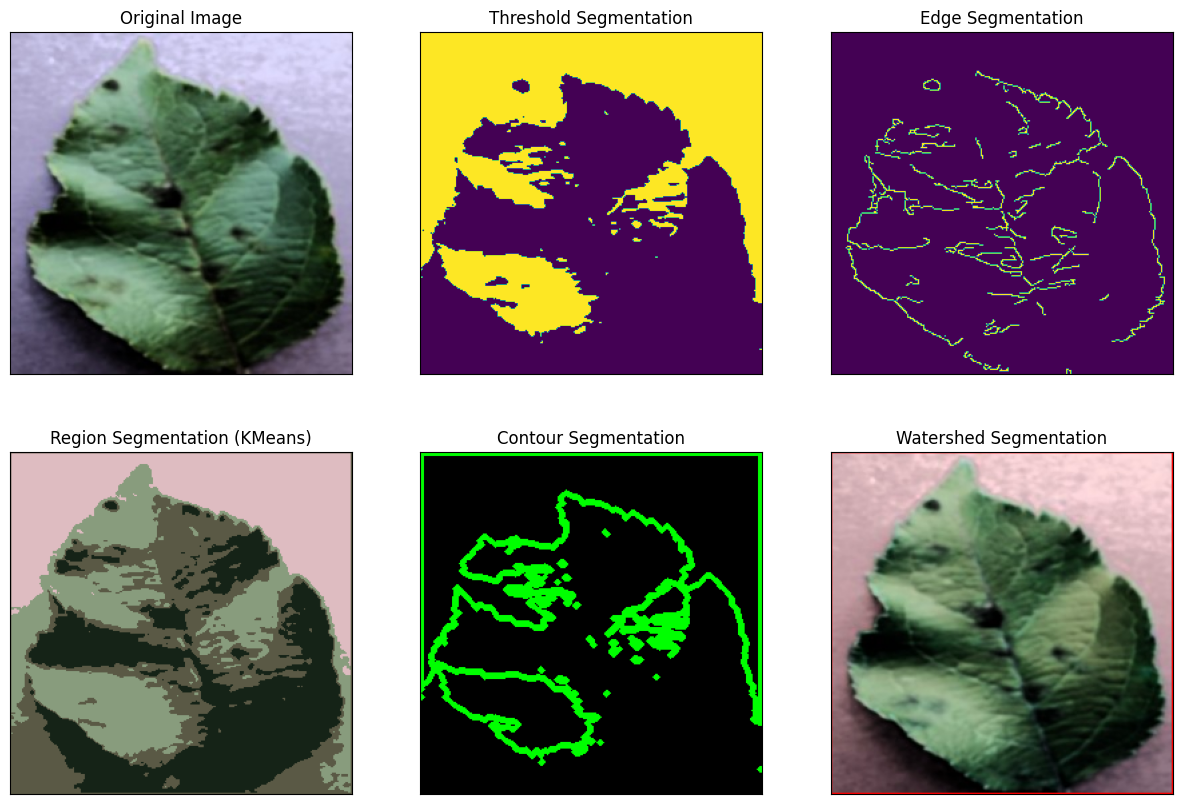

Contour Areas (Total Area of Segmented Objects):
Threshold Segmentation: 28726
Edge Segmentation: 2538
Region Segmentation: 31862
Contour Segmentation: 9943
Watershed Segmentation: 28089
KMeans Segmentation: 31107


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the contour area
def calculate_contour_area(segmented_img):
    # Check if the image is already grayscale
    if len(segmented_img.shape) == 2:
        # If grayscale, directly use it
        binary_img = segmented_img
    else:
        # If not grayscale, convert to grayscale
        gray_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
        # Threshold the grayscale image to create a binary image
        _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    # Calculate the area by summing the non-zero pixel values
    area = np.sum(binary_img == 255)
    return area
# Function to display segmented images and contour areas
def display_segmented_images(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: {image_path} not found.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Threshold Segmentation
    _, thresh_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
    threshold_area = calculate_contour_area(thresh_img)

    # 2. Edge Segmentation
    edges_img = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 100, 200)
    edge_area = calculate_contour_area(edges_img)

    # 3. Region Segmentation using KMeans
    Z = img.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    K = 4  # Number of clusters (regions)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(img.shape)
    region_area = calculate_contour_area(segmented_img)

    # 4. Contour Segmentation
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_img, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(img)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 3)
    contour_area = calculate_contour_area(contour_img)

    # 5. Watershed Segmentation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_bg = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=3)

    # Convert sure_fg to uint8 to match sure_bg's type
    sure_fg = sure_fg.astype(np.uint8)

    unknown = cv2.subtract(sure_bg, sure_fg)
    markers = np.zeros_like(gray, dtype=np.int32)
    markers[sure_fg == 255] = 1
    markers[sure_bg == 255] = 2
    markers[unknown == 255] = 0
    cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]
    watershed_img = img
    watershed_area = calculate_contour_area(watershed_img)

    # 6. KMeans Segmentation
    Z = img.reshape((-1, 3))
    Z = np.float32(Z)
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(img.shape)
    kmeans_area = calculate_contour_area(segmented_img)

    # Display all segmented images
    titles = ['Original Image', 'Threshold Segmentation', 'Edge Segmentation',
              'Region Segmentation (KMeans)', 'Contour Segmentation',
              'Watershed Segmentation', 'KMeans Segmentation']
    images = [img_rgb, thresh_img, edges_img, segmented_img, contour_img, watershed_img, segmented_img]

    plt.figure(figsize=(15, 10))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])  # Hide the ticks
    plt.show()

    # Print the contour areas for each segmentation method
    print("Contour Areas (Total Area of Segmented Objects):")
    print(f"Threshold Segmentation: {threshold_area}")
    print(f"Edge Segmentation: {edge_area}")
    print(f"Region Segmentation: {region_area}")
    print(f"Contour Segmentation: {contour_area}")
    print(f"Watershed Segmentation: {watershed_area}")
    print(f"KMeans Segmentation: {kmeans_area}")

# Example usage
sample_image_path = '/content/dataset/preprocessed/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'  # Update with an actual image path
display_segmented_images(sample_image_path)

**Feature Extraction**

In [31]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops # Correct import

# Function to extract GLCM (Texture) features
def extract_glcm_features(image_gray):
    # Calculate GLCM (Gray Level Co-occurrence Matrix)
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'ASM': asm,
        'energy': energy,
        'correlation': correlation
    }

# Function to extract color histogram features
def extract_color_histogram_features(image):
    # Split the image into Red, Green, and Blue channels
    channels = cv2.split(image)

    # Calculate histograms for each channel (normalized)
    hist_red = cv2.calcHist([channels[2]], [0], None, [256], [0, 256]) / image.size
    hist_green = cv2.calcHist([channels[1]], [0], None, [256], [0, 256]) / image.size
    hist_blue = cv2.calcHist([channels[0]], [0], None, [256], [0, 256]) / image.size

    return {
        'hist_red': hist_red.flatten(),
        'hist_green': hist_green.flatten(),
        'hist_blue': hist_blue.flatten()
    }

# Function to extract shape features (using contours)
def extract_shape_features(image_gray):
    # Threshold the image to obtain binary mask
    _, thresh = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour is the object (leaf)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)

        # Calculate shape features
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)

        return {
            'area': area,
            'perimeter': perimeter
        }
    else:
        return {
            'area': 0,
            'perimeter': 0
        }

# Main function to extract all features
def extract_features(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale for GLCM and shape features
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract GLCM (texture) features
    glcm_features = extract_glcm_features(image_gray)

    # Extract color histogram features
    color_histogram_features = extract_color_histogram_features(image)

    # Extract shape features
    shape_features = extract_shape_features(image_gray)

    # Combine all features into one dictionary
    features = {**glcm_features, **color_histogram_features, **shape_features}

    return features

# Example usage
image_path = '/content/dataset/preprocessed/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
features = extract_features(image_path)

# Print features in an ordered and neatly formatted manner
ordered_keys = sorted(features.keys())

# Display each feature in a readable format
for key in ordered_keys:
    print(f"{key}: {features[key]}")

ASM: 0.0004929939337484381
area: 23306.5
contrast: 33.97550551470588
correlation: 0.9960220912762151
dissimilarity: 3.267325367647059
energy: 0.022203466705639417
hist_blue: [0.00387065 0.00266012 0.00256348 0.00258891 0.00239054 0.00256348
 0.00238546 0.00232951 0.00198364 0.0021464  0.00184631 0.00202942
 0.00201416 0.00210063 0.00186157 0.00207011 0.00216675 0.00223287
 0.0019989  0.00221252 0.00191243 0.00187174 0.00192261 0.00177511
 0.0017395  0.00158183 0.00179036 0.00158691 0.00156148 0.00163778
 0.00137329 0.00142415 0.00151062 0.00168864 0.00159709 0.00159709
 0.00147502 0.00153605 0.001592   0.00150045 0.00146993 0.00133769
 0.00132243 0.00141398 0.00125631 0.00142924 0.00139872 0.00132243
 0.00140889 0.0015564  0.00152079 0.00163269 0.00155131 0.00139872
 0.00163778 0.00154114 0.00156148 0.00128682 0.00146993 0.00143941
 0.00121053 0.0014445  0.00132243 0.00119019 0.00131734 0.00129191
 0.00110372 0.00121053 0.00121562 0.00119527 0.00116984 0.00121562
 0.00115458 0.00120036

**Visualization**

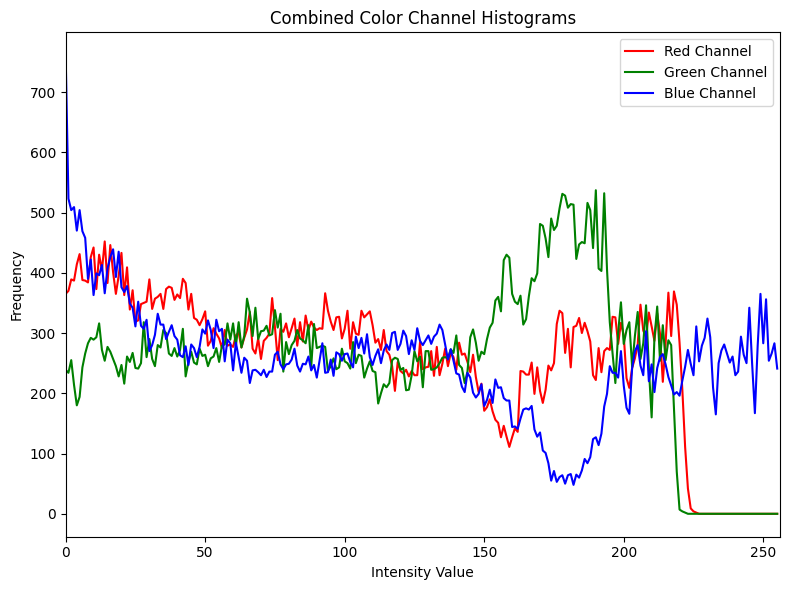

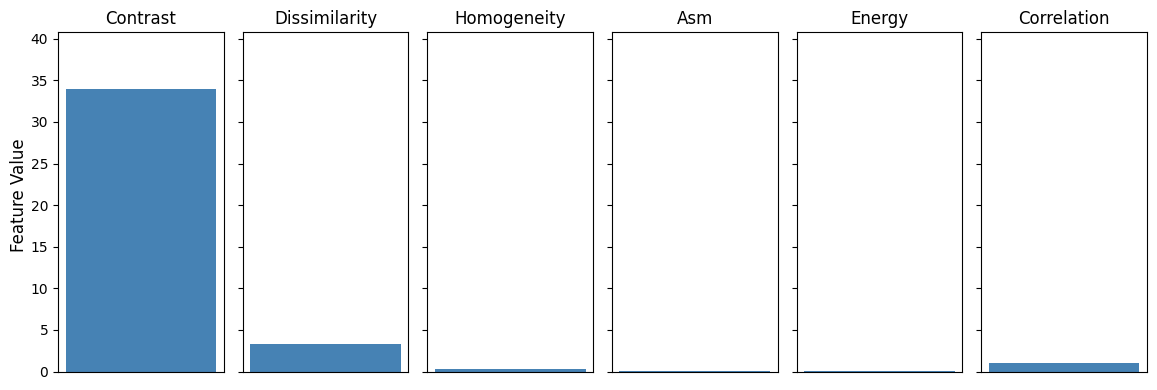

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

# Function to extract GLCM (Texture) features
def extract_glcm_features(image_gray):
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'ASM': asm,
        'energy': energy,
        'correlation': correlation
    }

# Function to extract color histograms
def extract_color_histogram_features(image):
    channels = cv2.split(image)

    hist_red = cv2.calcHist([channels[2]], [0], None, [256], [0, 256])
    hist_green = cv2.calcHist([channels[1]], [0], None, [256], [0, 256])
    hist_blue = cv2.calcHist([channels[0]], [0], None, [256], [0, 256])

    return hist_red, hist_green, hist_blue

# Function to plot color histograms in a combined chart
def plot_combined_color_histogram(hist_red, hist_green, hist_blue):
    plt.figure(figsize=(8, 6))
    plt.plot(hist_red, color='red', label='Red Channel')
    plt.plot(hist_green, color='green', label='Green Channel')
    plt.plot(hist_blue, color='blue', label='Blue Channel')

    plt.title('Combined Color Channel Histograms')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xlim([0, 256])
    plt.tight_layout()
    plt.show()

# Function to plot GLCM features as individual vertical bar graphs in one row
def plot_glcm_features_in_one_row(glcm_features):
    feature_names = list(glcm_features.keys())
    feature_values = list(glcm_features.values())

    # Create subplots (1 row, 6 columns for 6 GLCM features)
    fig, axes = plt.subplots(1, len(feature_names), figsize=(12, 4), sharey=True)

    for i, ax in enumerate(axes):
        ax.bar(feature_names[i], feature_values[i], color='steelblue')
        ax.set_ylim(0, max(feature_values) * 1.2)
        ax.set_title(feature_names[i].capitalize())
        ax.set_xticks([])

    # Add common Y-label for all graphs
    fig.text(0.04, 0.5, 'Feature Value', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(left=0.08)
    plt.show()

# Main function to extract and plot features
def extract_and_plot_features(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale for GLCM
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract GLCM features
    glcm_features = extract_glcm_features(image_gray)

    # Extract color histograms
    hist_red, hist_green, hist_blue = extract_color_histogram_features(image)

    # Plot combined color histograms
    plot_combined_color_histogram(hist_red, hist_green, hist_blue)

    # Plot GLCM feature values as small vertical bars in one row
    plot_glcm_features_in_one_row(glcm_features)

# Example usage
image_path = '/content/dataset/preprocessed/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
extract_and_plot_features(image_path)